In [ ]:
import pandas as pd
from six.moves import cPickle
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading

Loading the review data file and business file

In [ ]:
df_full = pd.read_csv('/content/drive/MyDrive/CF Project yelp/CSV/review.csv')

In [ ]:
df_full.head()

,Unnamed: 0,review_id,business_id,user_id,stars,useful,funny,cool,text,date
0,0,lWC-xP3rd6obsecCYsGZRg,buF9druCkbuXLX526sGELQ,ak0TdVmGKo4pwqdJSTLwWw,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,1,8bFej1QE5LXp4O05qjGqXA,RA4V8pr014UyUbDvI-LW2A,YoVfDbnISlW0f7abNQACIg,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,2,NDhkzczKjLshODbqDoNLSg,_sS2LBIGNT5NQb6PD1Vtjw,eC5evKn1TWDyHCyQAwguUw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,3,T5fAqjjFooT4V0OeZyuk1w,0AzLzHfOJgL7ROwhdww2ew,SFQ1jcnGguO0LYWnbbftAA,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4,sjm_uUcQVxab_EeLCqsYLg,8zehGz9jnxPqXtOc7KaJxA,0kA0PAJ8QFMeveQWHFqz2A,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [ ]:
df_full.drop("Unnamed: 0",inplace=True,axis=1)

In [ ]:
df_full.columns = (df_full.columns.str.strip().str.lower()
              .str.replace(' ', '_')
              .str.replace('(', '')
              .str.replace(')', ''))

In [ ]:
df_bus = pd.read_csv('/content/drive/MyDrive/CF Project yelp/CSV/business.csv')

In [ ]:
print("Columns in business data file are:")
for i in df_bus.columns:
    print(i)

Columns in business data file are:
Unnamed: 0
business_id 
name
city
state
stars
review_count
categories
latitude
longitude
is_open
postal_code


In [ ]:
df_bus.drop("Unnamed: 0",inplace=True,axis=1)

In [ ]:
df_bus.columns = (df_bus.columns.str.strip().str.lower()
              .str.replace(' ', '_')
              .str.replace('(', '')
              .str.replace(')', ''))

In [ ]:
df_bus.head()

,business_id,name,city,state,stars,review_count,categories,latitude,longitude,is_open,postal_code
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,Boulder,CO,4.0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",40.017544,-105.283348,1,80302
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,Portland,OR,4.0,126,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",45.588906,-122.593331,1,97218
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,Portland,OR,4.5,13,"Antiques, Fashion, Used, Vintage & Consignment...",45.511907,-122.613693,1,97214
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,Orange City,FL,3.0,8,"Beauty & Spas, Hair Salons",28.914482,-81.295979,1,32763
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,Atlanta,GA,4.0,14,"Gyms, Active Life, Interval Training Gyms, Fit...",33.747027,-84.353424,1,30316


# 2. Data Exploration, Data Cleaning and Matrix Building 

## 2.a. Number of businesses in each city:

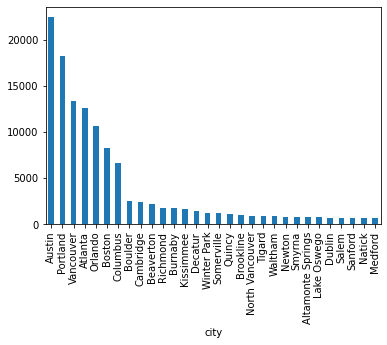

In [ ]:
df_bus_groups = df_bus.groupby('city').count()
df_bus_city = df_bus_groups['name']
df_bus_city_sorted = df_bus_city.sort_values(ascending = False)
df_bus_city_sorted[:30].plot(kind = 'bar')

## 2.b. Different Type of Businesses and their Count:

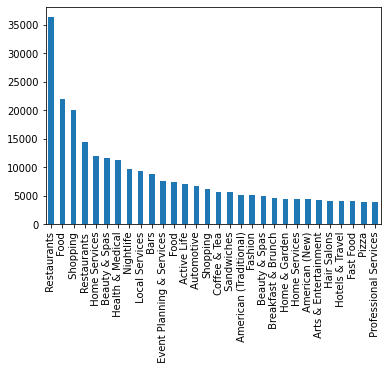

In [ ]:
uniq_cat_dict = {}
for i in df_bus.categories:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')

## 2.c. Business and City Ordered pairs and their count:

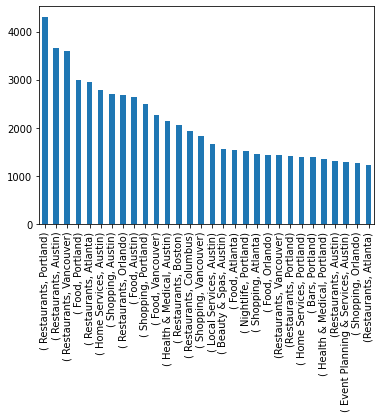

In [ ]:
business_city = {}
n = len(df_bus)
for i in range(n):
    k1 = str(df_bus.categories.iloc[i]).split(',')
    k2 = df_bus.city.iloc[i]
    for j in k1:
        k = (j,k2)
        if k not in business_city.keys():
            business_city[k] = 1
        else:
            business_city[k] += 1
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending = False, inplace = True)
business_city_series[:30].plot(kind = 'bar')

## Inferences from 2.a, 2.b and 2.c

It can be seen that most of the businesses listed on the Yelp are Restaurants, Shopping places and Recreational Centers. For this given data set (obtained from Yelp's Website), top cities with maximum businesses are Portland, Austin, and Vancuover.

## 2.d. Cleaning the review data

Dropping the unwanted columns like 'text': review text, 'useful': Number of people rated it useful, 'date',etc.
The columns left are 'user_id', 'business_id' and 'stars'.

In [ ]:
df_reduced = df_full.drop(['text','useful','cool', 'date', 'funny'], axis = 1)
df_reduced.head()

,review_id,business_id,user_id,stars
0,lWC-xP3rd6obsecCYsGZRg,buF9druCkbuXLX526sGELQ,ak0TdVmGKo4pwqdJSTLwWw,4.0
1,8bFej1QE5LXp4O05qjGqXA,RA4V8pr014UyUbDvI-LW2A,YoVfDbnISlW0f7abNQACIg,4.0
2,NDhkzczKjLshODbqDoNLSg,_sS2LBIGNT5NQb6PD1Vtjw,eC5evKn1TWDyHCyQAwguUw,5.0
3,T5fAqjjFooT4V0OeZyuk1w,0AzLzHfOJgL7ROwhdww2ew,SFQ1jcnGguO0LYWnbbftAA,2.0
4,sjm_uUcQVxab_EeLCqsYLg,8zehGz9jnxPqXtOc7KaJxA,0kA0PAJ8QFMeveQWHFqz2A,4.0


## 2.e. Merging the business data with the review data

Merging the business data and the review data on the 'business_id'. Information like 'city' of the business and 'categories' of the business were taken from the business data file.

In [ ]:
df_merged = df_reduced.merge(df_bus[['city','categories', 'business_id']], how = 'outer', on= 'business_id')
df_merged.head()

,review_id,business_id,user_id,stars,city,categories
0,lWC-xP3rd6obsecCYsGZRg,buF9druCkbuXLX526sGELQ,ak0TdVmGKo4pwqdJSTLwWw,4.0,Beverly,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
1,hpcZLEzqD4_gPi6eSVi_Bg,buF9druCkbuXLX526sGELQ,Y-j2svl0M_5-jF1ehYuNPQ,2.0,Beverly,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
2,3FvY1Se8y2WXqTbaANOqMw,buF9druCkbuXLX526sGELQ,xUCX4GhBpeWxZB0l2lmt_w,5.0,Beverly,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
3,C1uQNP2ehBktS43ZRMEvkg,buF9druCkbuXLX526sGELQ,2M6KFsWIUXElqcQRz4A0Qg,5.0,Beverly,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
4,Cja8_35_kQDnF9g4voikzw,buF9druCkbuXLX526sGELQ,t5SRIRU6INiAyVkiMJhRPA,1.0,Beverly,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."


In [ ]:
df_cleaned = df_merged.dropna()

## 2.f. Getting the top Business and City for which highest number of reviews are obtained

In [ ]:
def topm_num_reviews_for_city_n_biz(df,m):
    business_city_count = {}
    n = len(df)
    for i in range(n):
        k1 = str(df.categories.iloc[i]).split(',')
        k2 = df.city.iloc[i]
        for j in k1:
            k = (j,k2)
            if k not in business_city_count.keys():
                business_city_count[k] = 1
            else:
                business_city_count[k] += 1
    business_city_count_series = pd.Series(business_city_count)
    business_city_count_series.sort_values(ascending = False, inplace = True)
    return business_city_count_series

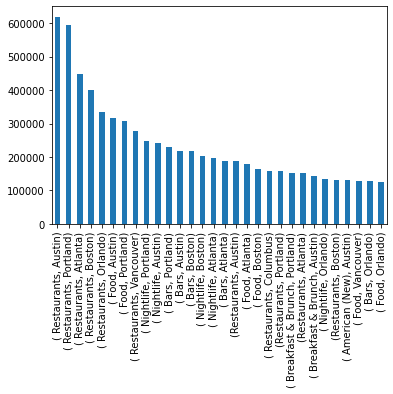

In [ ]:
review_business_city = topm_num_reviews_for_city_n_biz(df_cleaned,10)
review_business_city[:30].plot(kind = 'bar')

In [ ]:
rest_austin_reviews = df_cleaned[(df_cleaned.city == 'Austin') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_austin_reviews.shape

(619340, 6)

In [ ]:
rest_portland_reviews = df_cleaned[(df_cleaned.city == 'Portland') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_portland_reviews.shape

(594339, 6)

In [ ]:
def get_clean_df(df, min_user_review = 30, min_res_review = 0, cols = ['user_id', 'business_id', 'stars']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new[cols[1]+'_freq'] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_clean = df_new[df_new[cols[1]+'_freq']>=min_res_review]
    df_clean[cols[0]+'_freq'] = df_clean.groupby(cols[0])[cols[0]].transform('count')
    df_clean_2 = df_clean[df_clean[cols[0]+'_freq']>=min_user_review]
    return df_clean_2

In [ ]:
def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

In [ ]:
u_20_austin = get_sparse_matrix(get_clean_df(rest_austin_reviews, min_user_review=20))
u_30_portland = get_sparse_matrix(get_clean_df(rest_portland_reviews, min_user_review=30))
print(get_sparsity(u_20_austin))
print(get_sparsity(u_30_portland))
print(u_20_austin.shape)
print(u_30_portland.shape)

0.9881749488056111
0.9858682495542459
(3697, 3561)
(1710, 4126)


In [ ]:
user_min_10_austin_res = get_clean_df(rest_austin_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Austin: ", user_min_10_austin_res.shape[0])
user_min_10_portland_res = get_clean_df(rest_portland_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Portland: ", user_min_10_portland_res.shape[0])

Number of Reviews for Restaurants in Austin:  244787
Number of Reviews for Restaurants in Portland:  216969


In [ ]:
print("Unique Restaurants in Austin =",len(user_min_10_austin_res.business_id.unique()))
print("Unique Users in Austin =",len(user_min_10_austin_res.user_id.unique()))
print("Unique Restaurants in Portland =",len(user_min_10_portland_res.business_id.unique()))
print("Unique Users in Portland =",len(user_min_10_portland_res.user_id.unique()))

Unique Restaurants in Austin = 3621
Unique Users in Austin = 9666
Unique Restaurants in Portland = 4273
Unique Users in Portland = 8968


In [ ]:
from pandas.api.types import CategoricalDtype
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars'].tolist()
    cat_type = CategoricalDtype(categories=unique_users)
    row = df['user_id'].astype(cat_type).cat.codes
    cat_type2 = CategoricalDtype(categories=unique_bus)
    col = df['business_id'].astype(cat_type2).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix

In [ ]:
sm_user_10_austin_rest = get_sparse_matrix(user_min_10_austin_res)
print("Shape of ratings matrix for Restaurants in Austria =",sm_user_10_austin_rest.shape)
sm_user_10_portland_rest = get_sparse_matrix(user_min_10_portland_res)
print("Shape of ratings matrix for Restaurants in Portland =",sm_user_10_portland_rest.shape)

Shape of ratings matrix for Restaurants in Austria = (9666, 3621)
Shape of ratings matrix for Restaurants in Portland = (8968, 4273)


In [ ]:
sparsity_austin = 1 - sm_user_10_austin_rest.nnz/(sm_user_10_austin_rest.shape[0]*sm_user_10_austin_rest.shape[1])
sparsity_portland = 1 - sm_user_10_portland_rest.nnz/(sm_user_10_portland_rest.shape[0]*sm_user_10_portland_rest.shape[1])
print("Sparsity of ratings matrix for Restaurants in Austin = ", sparsity_austin)
print("Sparsity of ratings matrix for Restaurants in Portland = ", sparsity_portland)

Sparsity of ratings matrix for Restaurants in Austin =  0.9933968534126829
Sparsity of ratings matrix for Restaurants in Portland =  0.9946274378485492


In [ ]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [ ]:
sm_u_10_austin_res_train, sm_u_10_austin_res_val, sm_u_10_austin_res_test = train_val_test_split(sm_user_10_austin_rest)
sm_u_10_portland_res_train, sm_u_10_portland_res_val, sm_u_10_portland_res_test =  train_val_test_split(sm_user_10_portland_rest)

In [ ]:
print(sm_u_10_austin_res_train.nnz, sm_u_10_austin_res_val.nnz, sm_u_10_austin_res_test.nnz)
print(sm_u_10_portland_res_train.nnz, sm_u_10_portland_res_val.nnz, sm_u_10_portland_res_test.nnz)

192454 19328 19332
170008 17934 17936


In [ ]:
u_20_train, u_20_val, u_20_test = train_val_test_split(u_20_austin, num_review_val= 7, num_review_test= 3)

# 3. Model Building:

## 3.1 SVD

## For Restaurants in Austin

In [ ]:
U_austin_res, S_austin_res, Vt_austin_res = np.linalg.svd(sm_u_10_austin_res_train.todense())#k = min(sm_u_10_austin_res_train.shape)-1)

In [ ]:
print("smallest singular value = ",min(S_austin_res))
print("largest singular value = ",max(S_austin_res))
S_austin_res_dia = np.diag(S_austin_res)

smallest singular value =  1.6828708296355819e-15
largest singular value =  415.825972133932


** Printing top 20 singular values**

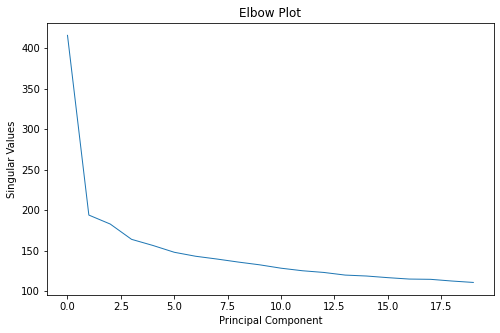

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_austin_res[:20], '-', linewidth=1)
plt.title('Elbow Plot')
# plt.xticks(np.arange(0, S_austin_res.shape[0]+1, 50), rotation='vertical')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

## For Restaurants in Portland

In [ ]:
U_portland_res, S_portland_res, Vt_portland_res = np.linalg.svd(sm_u_10_portland_res_train.todense())#k = min(sm_u_10_austin_res_train.shape)-1)

In [ ]:
print("smallest singular value = ",min(S_portland_res))
print("largest singular value = ",max(S_portland_res))
S_portland_res_dia = np.diag(S_portland_res)

smallest singular value =  1.9105243741165438e-15
largest singular value =  384.2195955473826


** Printing top 20 singular values**

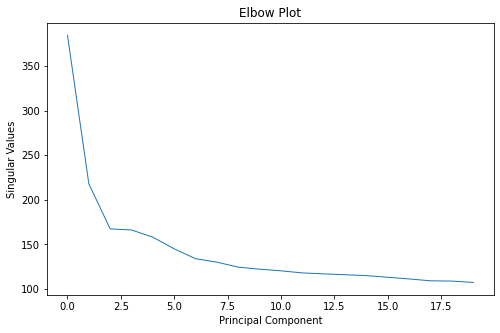

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_portland_res[:20], '-', linewidth=1)
plt.title('Elbow Plot')
# plt.xticks(np.arange(0, S_austin_res.shape[0]+1, 50), rotation='vertical')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

In [ ]:
def approx_err(k, A, U, S, Vt):
    rec_A = np.dot(U[:, :k], np.dot(S[:k,:k], Vt[:k, :]))
    idx = np.where(A>0);
    diff = A[idx] - rec_A[idx]
    return np.linalg.norm(diff)**2/diff.shape[1]

## For Restaurants in Austin

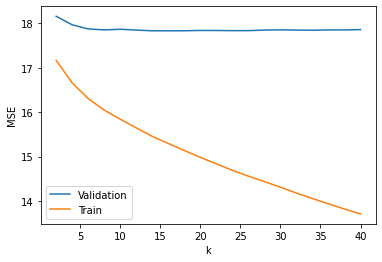

In [ ]:
k = np.linspace(2,40,20, dtype = int)
errors_svd_val = {}
errors_svd_train = {}
for i in k:
    errors_svd_val[i] = approx_err(i, sm_u_10_austin_res_val.todense(), U_austin_res, S_austin_res_dia, Vt_austin_res)
    errors_svd_train[i] = approx_err(i, sm_u_10_austin_res_train.todense(), U_austin_res, S_austin_res_dia, Vt_austin_res)

plt.plot(list(errors_svd_val.keys()),list(errors_svd_val.values()), label = 'Validation')
plt.plot(list(errors_svd_train.keys()),list(errors_svd_train.values()), label = 'Train')
plt.xlabel("k")
plt.ylabel("MSE")
plt.legend()

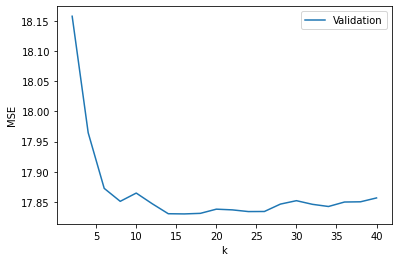

In [ ]:
##Separately plotting the Validation error
plt.plot(list(errors_svd_val.keys()),list(errors_svd_val.values()), label = 'Validation')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()
plt.legend()

Text(0, 0.5, 'Principal Component 2')

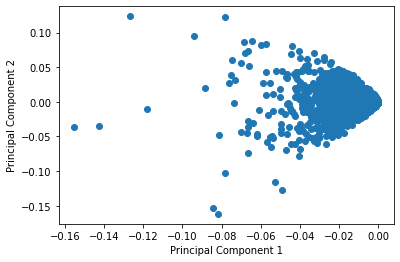

In [ ]:
plt.scatter(np.ravel(U_austin_res[:,0]),np.ravel(U_austin_res[:,1]), label = 'Scatter plot for first two PCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Best Validation MSE for SVD

In [ ]:
Best_Val_MSE_SVD_austin = approx_err(10, sm_u_10_austin_res_val.todense(), U_austin_res, S_austin_res_dia, Vt_austin_res)
print('Best Validation MSE for SVD for Restaurants in Austin= ', Best_Val_MSE_SVD_austin)

Best Validation MSE for SVD for Restaurants in Austin=  17.864716085477156


Non Zero Indices in Train, Val and Test

In [ ]:
train_austin_nnz = sm_u_10_austin_res_train.nonzero()
val_austin_nnz = sm_u_10_austin_res_val.nonzero()
test_austin_nnz = sm_u_10_austin_res_test.nonzero()

In [ ]:
recon_matrix_svd_austin = np.dot(U_austin_res[:, :10], np.dot(S_austin_res_dia[:10,:10], Vt_austin_res[:10, :]))
train_preds_svd_austin = np.ravel(recon_matrix_svd_austin[train_austin_nnz])
val_preds_svd_austin = np.ravel(recon_matrix_svd_austin[val_austin_nnz])
test_preds_svd_austin = np.ravel(recon_matrix_svd_austin[test_austin_nnz])

## For Restaurants in Portland

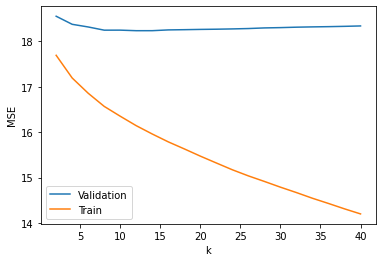

In [ ]:
k = np.linspace(2,40,20, dtype = int)
errors_svd_val_portland = {}
errors_svd_train_portland = {}
for i in k:
    errors_svd_val_portland[i] = approx_err(i, sm_u_10_portland_res_val.todense(), U_portland_res, S_portland_res_dia, Vt_portland_res)
    errors_svd_train_portland[i] = approx_err(i, sm_u_10_portland_res_train.todense(), U_portland_res, S_portland_res_dia, Vt_portland_res)

plt.plot(list(errors_svd_val_portland.keys()),list(errors_svd_val_portland.values()), label = 'Validation')
plt.plot(list(errors_svd_train_portland.keys()),list(errors_svd_train_portland.values()), label = 'Train')
plt.xlabel("k")
plt.ylabel("MSE")
plt.legend()

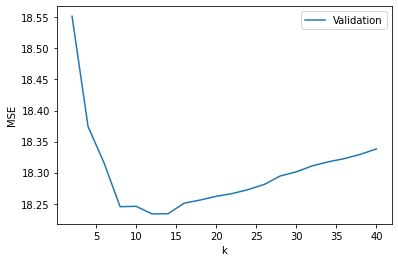

In [ ]:
##Separately plotting the Validation error
plt.plot(list(errors_svd_val_portland.keys()),list(errors_svd_val_portland.values()), label = 'Validation')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

Best Validation MSE for SVD

In [ ]:
Best_Val_MSE_SVD_portland = approx_err(16, sm_u_10_portland_res_val.todense(), U_portland_res, S_portland_res_dia, Vt_portland_res)
print('Best Validation MSE for SVD for Restaurants in Portland= ', Best_Val_MSE_SVD_portland)

Best Validation MSE for SVD for Restaurants in Portland=  18.250843994107285


In [ ]:
train_portland_nnz = sm_u_10_portland_res_train.nonzero()
val_portland_nnz = sm_u_10_portland_res_val.nonzero()
test_portland_nnz = sm_u_10_portland_res_test.nonzero()

In [ ]:
recon_matrix_svd_portland = np.dot(U_portland_res[:, :15], np.dot(S_portland_res_dia[:15,:15], Vt_portland_res[:15, :]))
train_preds_svd_portland = np.ravel(recon_matrix_svd_portland[train_portland_nnz])
val_preds_svd_portland = np.ravel(recon_matrix_svd_portland[val_portland_nnz])
test_preds_svd_portland = np.ravel(recon_matrix_svd_portland[test_portland_nnz])

## SVD with Bias Correction

In [ ]:
global_bias = np.sum(sm_u_10_austin_res_train)/sm_u_10_austin_res_train.nnz
sm_u_10_austin_res_train_wo_bias = sm_u_10_austin_res_train.todense() - global_bias
U_austin_res_wo_bias, S_austin_res_wo_bias, Vt_austin_res_wo_bias = np.linalg.svd(sm_u_10_austin_res_train_wo_bias)
print("smallest singular value = ",min(S_austin_res_wo_bias))
print("largest singular value = ",max(S_austin_res_wo_bias))
S_austin_res_dia_wo_bias = np.diag(S_austin_res_wo_bias)

smallest singular value =  2.5942567351589408e-15
largest singular value =  23806.437767711526


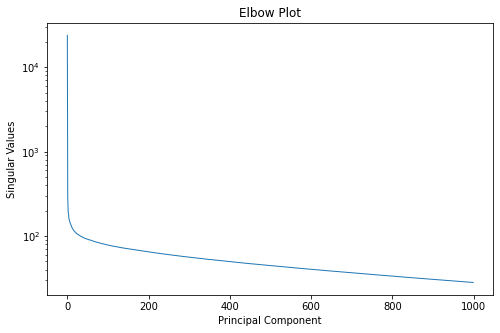

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.semilogy(S_austin_res_wo_bias[:1000], '-', linewidth=1)
plt.title('Elbow Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

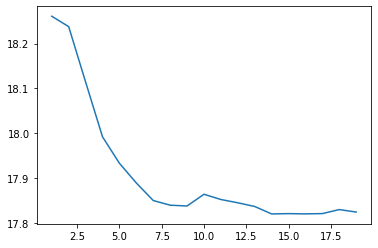

In [ ]:
k_wo_bias = np.arange(1,20)
errors_svd_wo_bias = {}
sm_u_10_austin_res_val_wo_bias = sm_u_10_austin_res_val.todense() - global_bias 

for i in k_wo_bias:
    sm_u_10_austin_res_val_wo_bias_rec = np.dot(U_austin_res_wo_bias[:, :i], np.dot(S_austin_res_dia_wo_bias[:i,:i], Vt_austin_res_wo_bias[:i, :]))
    idx_wo_bias = np.where(sm_u_10_austin_res_val.todense()>0);
    diff_wo_bias = sm_u_10_austin_res_val_wo_bias[idx_wo_bias] - sm_u_10_austin_res_val_wo_bias_rec[idx_wo_bias]
    errors_svd_wo_bias[i] = np.linalg.norm(diff_wo_bias)**2/diff_wo_bias.shape[1]
plt.plot(list(errors_svd_wo_bias.keys()),list(errors_svd_wo_bias.values()))

In [ ]:
def find_global_user_res_bias(ratings_matrix):
    dense_matrix = ratings_matrix.todense()
    mask_matrix = (dense_matrix>0).astype(int)
    user_bias = np.sum(dense_matrix, axis = 1)/np.sum(mask_matrix, axis = 1)
    res_bias =  np.sum(dense_matrix, axis = 0)/np.sum(mask_matrix, axis = 0)
    user_bias = np.nan_to_num(user_bias)
    res_bias = np.nan_to_num(res_bias)
    user_bias = user_bias.reshape(-1,1)
    res_bias = res_bias.reshape(1,-1)
    ratings_matrix_wo_bias = dense_matrix - np.tile(user_bias, (1,dense_matrix.shape[1]))- np.tile(res_bias, (dense_matrix.shape[0], 1))
    return user_bias, res_bias, ratings_matrix_wo_bias

## For Restaurants in Austin

In [ ]:
user_bias_ur, res_bias_ur, train_ur = find_global_user_res_bias(sm_u_10_austin_res_train)

In [ ]:
U_austin_res_wo_bias_ur, S_austin_res_wo_bias_ur, Vt_austin_res_wo_bias_ur = np.linalg.svd(train_ur)
print("smallest singular value = ",min(S_austin_res_wo_bias_ur))
print("largest singular value = ",max(S_austin_res_wo_bias_ur))
S_austin_res_dia_wo_bias_ur = np.diag(S_austin_res_wo_bias_ur)

smallest singular value =  1.2266364486762977e-15
largest singular value =  47308.34865287486


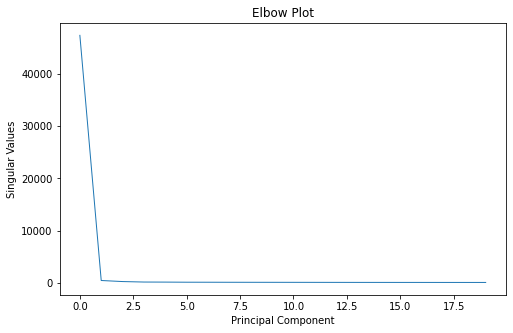

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_austin_res_wo_bias_ur[:20], '-', linewidth=1)
plt.title('Elbow Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

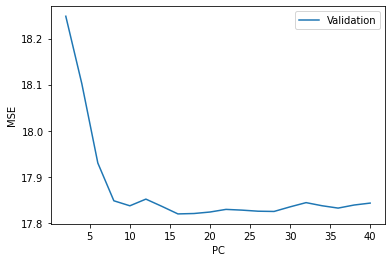

In [ ]:
k_wo_bias_ur = np.linspace(2,40,20, dtype = int)
errors_svd_wo_bias_ur = {}
sm_u_10_austin_res_val_wo_bias_ur = sm_u_10_austin_res_val.todense() - user_bias_ur - res_bias_ur

for i in k_wo_bias_ur:
    sm_u_10_austin_res_val_wo_bias_ur_rec = np.dot(U_austin_res_wo_bias_ur[:, :i], np.dot(S_austin_res_dia_wo_bias_ur[:i,:i], Vt_austin_res_wo_bias_ur[:i, :]))
    idx_wo_bias_ur = np.where(sm_u_10_austin_res_val.todense()>0);
    diff_wo_bias_ur = sm_u_10_austin_res_val_wo_bias_ur[idx_wo_bias_ur] - sm_u_10_austin_res_val_wo_bias_ur_rec[idx_wo_bias_ur]
    errors_svd_wo_bias_ur[i] = np.linalg.norm(diff_wo_bias_ur)**2/diff_wo_bias_ur.shape[1]
plt.plot(list(errors_svd_wo_bias_ur.keys()),list(errors_svd_wo_bias_ur.values()), label= 'Validation')
plt.xlabel('PC')
plt.ylabel('MSE')
plt.legend()

## For Restaurants in Portland

In [ ]:
user_bias_ur_portland, res_bias_ur_portland, train_ur_portland = find_global_user_res_bias(sm_u_10_portland_res_train)

In [ ]:
U_portland_res_wo_bias_ur, S_portland_res_wo_bias_ur, Vt_portland_res_wo_bias_ur = np.linalg.svd(train_ur_portland)
print("smallest singular value = ",min(S_portland_res_wo_bias_ur))
print("largest singular value = ",max(S_portland_res_wo_bias_ur))
S_portland_res_dia_wo_bias_ur = np.diag(S_portland_res_wo_bias_ur)

smallest singular value =  1.0267681801086373e-14
largest singular value =  50403.37708197539


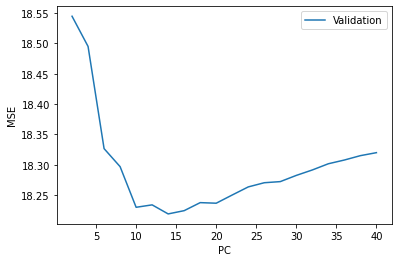

In [ ]:
k_wo_bias_ur = np.linspace(2,40,20, dtype = int)
errors_svd_wo_bias_ur_portland = {}
sm_u_10_portland_res_val_wo_bias_ur = sm_u_10_portland_res_val.todense() - user_bias_ur_portland - res_bias_ur_portland

for i in k_wo_bias_ur:
    sm_u_10_portland_res_val_wo_bias_ur_rec = np.dot(U_portland_res_wo_bias_ur[:, :i], np.dot(S_portland_res_dia_wo_bias_ur[:i,:i], Vt_portland_res_wo_bias_ur[:i, :]))
    idx_wo_bias_ur_portland = np.where(sm_u_10_portland_res_val.todense()>0);
    diff_wo_bias_ur_portland = sm_u_10_portland_res_val_wo_bias_ur[idx_wo_bias_ur_portland] - sm_u_10_portland_res_val_wo_bias_ur_rec[idx_wo_bias_ur_portland]
    errors_svd_wo_bias_ur_portland[i] = np.linalg.norm(diff_wo_bias_ur_portland)**2/diff_wo_bias_ur_portland.shape[1]
plt.plot(list(errors_svd_wo_bias_ur_portland.keys()),list(errors_svd_wo_bias_ur_portland.values()), label = 'Validation')
plt.xlabel('PC')
plt.ylabel('MSE')
plt.legend()

# 3.2 Cosine Similarity with correction for bias

In [ ]:
def similarity_matrix(train_matrix, between = 'users'):
    '''Returns the cosine similarity between users or restaurants'''
    if between == 'users':
        similarity = train_matrix*train_matrix.transpose()
    else:
        similarity = train_matrix.transpose()*train_matrix
    similarity_dense = similarity.todense() + 1e-8
    norm_array = np.sqrt(np.diag(similarity_dense))
    return similarity_dense/norm_array/norm_array.reshape(-1,1)

In [ ]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = np.mean(ratings, axis =1)
        ratings = (ratings - np.tile(user_bias, (ratings.shape[1],1)).T).copy()
        for i in range(ratings.shape[0]):
            top_k_users = np.argsort(similarity[:,i])[:-k-1:-1]
            pred[i] = np.dot(similarity[i,top_k_users],ratings[top_k_users,:])/np.sum(np.abs(similarity[i,top_k_users]))
        pred += np.tile(user_bias,(ratings.shape[1],1)).T
    else:
        item_bias = np.mean(ratings, axis=0)
        ratings = (ratings - np.tile(item_bias,(ratings.shape[0],1))).copy()
        for j in range(ratings.shape[1]):
            top_k_items = np.argsort(similarity[:,j])[:-k-1:-1]
            pred[:,j] = np.dot(similarity[top_k_items,j].T,ratings[:,top_k_items].T)/np.sum(np.abs(similarity[top_k_items,j]))
        pred += np.tile(item_bias,(ratings.shape[0],1))
        
    return pred

In [ ]:
def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
simi_austin_res = similarity_matrix(sm_u_10_austin_res_train, between='res')
simi_austin_res = np.array(simi_austin_res)
preds_cosine_austin = predict_topk_nobias(np.array(sm_u_10_austin_res_train.todense()),simi_austin_res,kind='res', k=1)
MSE_cosine_res = get_mse(preds_cosine_austin, np.array(sm_u_10_austin_res_val.todense()))
print("MSE for cosine Similarity between Restaurants =",MSE_cosine_res)

MSE for cosine Similarity between Restaurants = 18.954625413907284


In [ ]:
simi_austin_users = similarity_matrix(sm_u_10_austin_res_train, between='users')
simi_austin_users = np.array(simi_austin_users)
preds_cosine_austin_users = predict_topk_nobias(np.array(sm_u_10_austin_res_train.todense()),simi_austin_users,kind='user', k=1)
MSE_cosine_users = get_mse(preds_cosine_austin_users, np.array(sm_u_10_austin_res_val.todense()))
print("MSE for cosine Similarity between Users =",MSE_cosine_users)

MSE for cosine Similarity between Users = 18.954625413907284


## For Restaurants in Austin

In [ ]:
errors_cs_res_austin_val = {}
errors_cs_res_austin_train = {}
k_cs = np.arange(1, 40)
for i in k_cs:
    preds_cs_res_austin = predict_topk_nobias(np.array(sm_u_10_austin_res_train.todense()),simi_austin_res,kind='res', k=i)
    error_cs_val = get_mse(preds_cs_res_austin, np.array(sm_u_10_austin_res_val.todense()))
    error_cs_train = get_mse(preds_cs_res_austin, np.array(sm_u_10_austin_res_train.todense()))
    errors_cs_res_austin_val[i] = error_cs_val
    errors_cs_res_austin_train[i] = error_cs_train


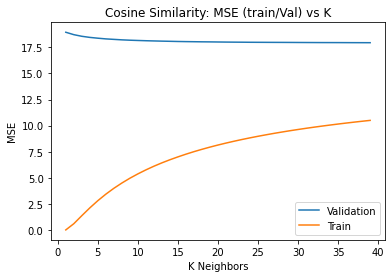

In [ ]:
plt.plot(list(errors_cs_res_austin_val.keys()),list(errors_cs_res_austin_val.values()), label = 'Validation')
plt.plot(list(errors_cs_res_austin_train.keys()),list(errors_cs_res_austin_train.values()), label = 'Train')
plt.xlabel('K Neighbors')
plt.ylabel('MSE')
plt.title('Cosine Similarity: MSE (train/Val) vs K')
plt.legend()

In [ ]:
preds_cosine_austin = predict_topk_nobias(np.array(sm_u_10_austin_res_train.todense()),simi_austin_res,kind='res', k=40)
Best_Val_MSE_Cosine_austin = get_mse(preds_cosine_austin, np.array(sm_u_10_austin_res_val.todense()))
print('Best Validation MSE for Cosine Similarity for Restaurants in Austin= ', Best_Val_MSE_Cosine_austin)

Best Validation MSE for Cosine Similarity for Restaurants in Austin=  17.949789493187883


In [ ]:
train_preds_cosine_austin = preds_cosine_austin[train_austin_nnz]
val_preds_cosine_austin = preds_cosine_austin[val_austin_nnz]
test_preds_cosine_austin = preds_cosine_austin[test_austin_nnz]

## For Restaurants in Portland

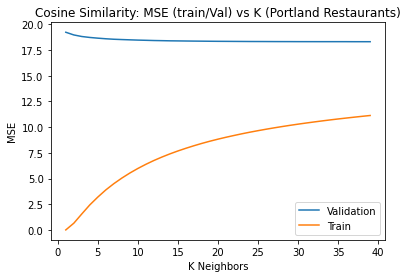

In [ ]:
errors_cs_res_portland_val = {}
errors_cs_res_portland_train = {}
k_cs = np.arange(1, 40)
simi_portland_res = similarity_matrix(sm_u_10_portland_res_train, between='res')
simi_portland_res = np.array(simi_portland_res)
for i in k_cs:
    preds_cs_res_portland = predict_topk_nobias(np.array(sm_u_10_portland_res_train.todense()),simi_portland_res,kind='res', k=i)
    error_cs_val = get_mse(preds_cs_res_portland, np.array(sm_u_10_portland_res_val.todense()))
    error_cs_train = get_mse(preds_cs_res_portland, np.array(sm_u_10_portland_res_train.todense()))
    errors_cs_res_portland_val[i] = error_cs_val
    errors_cs_res_portland_train[i] = error_cs_train
plt.plot(list(errors_cs_res_portland_val.keys()),list(errors_cs_res_portland_val.values()), label = 'Validation')
plt.plot(list(errors_cs_res_portland_train.keys()),list(errors_cs_res_portland_train.values()), label = 'Train')
plt.xlabel('K Neighbors')
plt.ylabel('MSE')
plt.title('Cosine Similarity: MSE (train/Val) vs K (Portland Restaurants)')
plt.legend()

In [ ]:
preds_cosine_portland = predict_topk_nobias(np.array(sm_u_10_portland_res_train.todense()),simi_portland_res,kind='res', k=40)
Best_Val_MSE_Cosine_portland = get_mse(preds_cosine_portland, np.array(sm_u_10_portland_res_val.todense()))
print('Best Validation MSE for Cosine Similarity for Restaurants in Portland= ', Best_Val_MSE_Cosine_portland)

Best Validation MSE for Cosine Similarity for Restaurants in Portland=  18.309133691438465


In [ ]:
train_preds_cosine_portland = preds_cosine_portland[train_portland_nnz]
val_preds_cosine_portland = preds_cosine_portland[val_portland_nnz]
test_preds_cosine_portland = preds_cosine_portland[test_portland_nnz]

# 3.3 ALS:

In [ ]:
def als(ratings_matrix, k=40, user_reg=0, res_reg=0, iters=10):
    '''Performs ALS for a given ratings_matrix and returns predictions using the latent vector representation User (U x K) and Restaurant (R x K)'''
    ratings_matrix = ratings_matrix.T
    user_vec = np.random.rand(ratings_matrix.shape[1],k).T
    res_vec = np.random.rand(ratings_matrix.shape[0],k).T
    for i in range(iters):
        for u in range(ratings_matrix.shape[1]):
            user_vec[:,u] = np.linalg.solve(np.dot(res_vec,res_vec.T) + user_reg * np.eye(res_vec.shape[0]), np.dot(res_vec,ratings_matrix[:,u]))
        for r in range(ratings_matrix.shape[0]):
            res_vec[:,r] = np.linalg.solve(np.dot(user_vec,user_vec.T) + res_reg * np.eye(user_vec.shape[0]), np.dot(user_vec,ratings_matrix[r,:].T))
        prediction = np.dot(res_vec.T, user_vec)
#         error = np.mean((ratings_matrix - prediction)**2)
    return np.dot(res_vec.T, user_vec).T

## For Restaurants in Austin

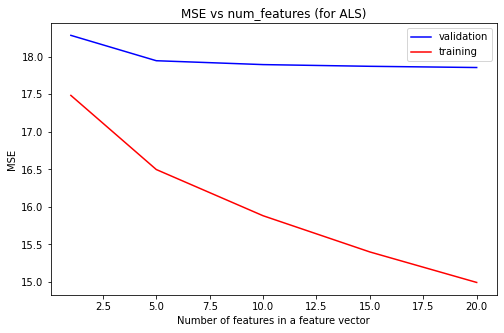

In [ ]:
num_features = np.linspace(1,20,5,dtype=int)
test_error_als = []
train_error_als = []
for i in num_features:
    preds_als = als(np.array(sm_u_10_austin_res_train.todense()), k=i, iters = 5)
    test_err = get_mse(preds_als, np.array(sm_u_10_austin_res_val.todense()))
    train_err = get_mse(preds_als, np.array(sm_u_10_austin_res_train.todense()))
    test_error_als.append(test_err)
    train_error_als.append(train_err)

fig = plt.figure(figsize=(8,5))
plt.plot(num_features,test_error_als,'b-',label = 'validation')
plt.plot(num_features,train_error_als,'r-', label = 'training')
plt.title('MSE vs num_features (for ALS)')
plt.xlabel('Number of features in a feature vector')
plt.ylabel('MSE')
plt.legend()

Text(0, 0.5, 'MSE')

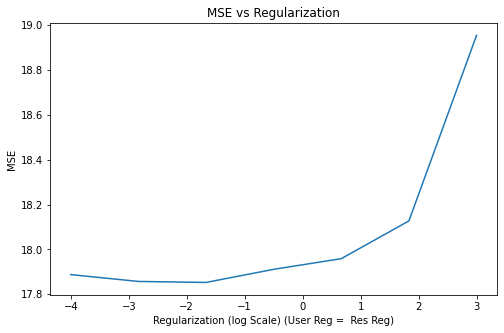

In [ ]:
user_reg= np.logspace(-4,3,7)
val_error_als = {}
# train_error_als = {}
fig = plt.figure(figsize=(8,5))
for i in user_reg:
    val_error_als[i] = []
    preds_als = als(np.array(sm_u_10_austin_res_train.todense()),k=10, iters = 5, user_reg=i, res_reg=i)
    val_err = get_mse(preds_als, np.array(sm_u_10_austin_res_val.todense()))
#         train_err = get_mse(preds_als, np.array(train.todense()))
    val_error_als[i].append(val_err)
#         train_error_als[i].append(train_err)
plt.plot(list(np.log10(user_reg)),list(val_error_als.values()))
#     plt.plot(np.log(res_reg),train_error_als[i], label = 'User_reg = '+ str(i))


plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

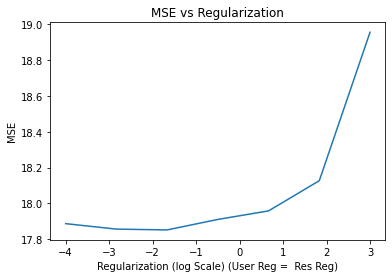

In [ ]:
plt.plot(list(np.log10(user_reg)),list(val_error_als.values()))
plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')

In [ ]:
preds_als_austin = als(np.array(sm_u_10_austin_res_train.todense()),k=10, iters = 5, user_reg=0.001 , res_reg=0.001)
Best_Val_MSE_als_austin = get_mse(preds_als_austin, np.array(sm_u_10_austin_res_val.todense()))
print('Best Validation MSE for ALS for Restaurants in Austin= ', Best_Val_MSE_als_austin)

Best Validation MSE for ALS for Restaurants in Austin=  17.87026493677067


In [ ]:
train_preds_als_austin = preds_als_austin[train_austin_nnz]
val_preds_als_austin = preds_als_austin[val_austin_nnz]
test_preds_als_austin = preds_als_austin[test_austin_nnz]

## For Restaurants in Portland

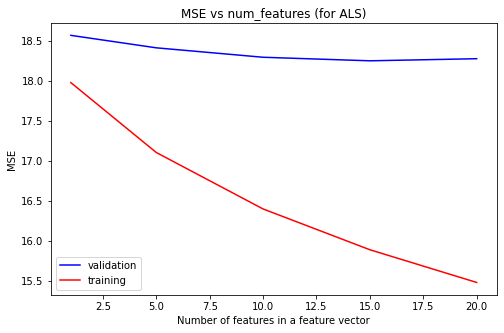

In [ ]:
num_features = np.linspace(1,20,5,dtype=int)
test_error_als_portland = []
train_error_als_portland = []
for i in num_features:
    preds_als = als(np.array(sm_u_10_portland_res_train.todense()), k=i, iters = 5)
    test_err = get_mse(preds_als, np.array(sm_u_10_portland_res_val.todense()))
    train_err = get_mse(preds_als, np.array(sm_u_10_portland_res_train.todense()))
    test_error_als_portland.append(test_err)
    train_error_als_portland.append(train_err)

fig = plt.figure(figsize=(8,5))
plt.plot(num_features,test_error_als_portland,'b-',label = 'validation')
plt.plot(num_features,train_error_als_portland,'r-', label = 'training')
plt.title('MSE vs num_features (for ALS)')
plt.xlabel('Number of features in a feature vector')
plt.ylabel('MSE')
plt.legend()

Text(0, 0.5, 'MSE')

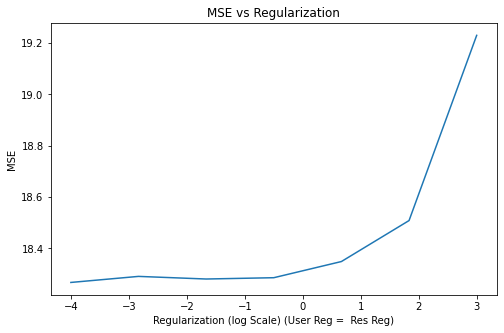

In [ ]:
user_reg= np.logspace(-4,3,7)
val_error_als = {}
# train_error_als = {}
fig = plt.figure(figsize=(8,5))
for i in user_reg:
    val_error_als[i] = []
    preds_als = als(np.array(sm_u_10_portland_res_train.todense()),k=10, iters = 5, user_reg=i, res_reg=i)
    val_err = get_mse(preds_als, np.array(sm_u_10_portland_res_val.todense()))
#         train_err = get_mse(preds_als, np.array(train.todense()))
    val_error_als[i].append(val_err)
#         train_error_als[i].append(train_err)
plt.plot(list(np.log10(user_reg)),list(val_error_als.values()))
#     plt.plot(np.log(res_reg),train_error_als[i], label = 'User_reg = '+ str(i))


plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

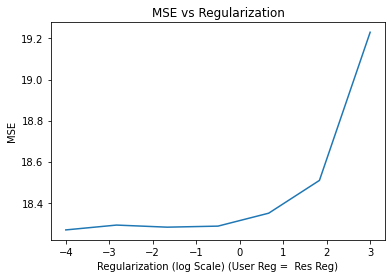

In [ ]:
plt.plot(list(np.log10(user_reg)),list(val_error_als.values()))
#     plt.plot(np.log(res_reg),train_error_als[i], label = 'User_reg = '+ str(i))


plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')

In [ ]:
preds_als_portland = als(np.array(sm_u_10_portland_res_train.todense()),k=10, iters = 5, user_reg=0.01, res_reg=0.01)
Best_Val_MSE_als_portland = get_mse(preds_als_portland, np.array(sm_u_10_portland_res_val.todense()))
print('Best Validation MSE for ALS for Restaurants in Portland= ', Best_Val_MSE_als_portland)

Best Validation MSE for ALS for Restaurants in Portland=  18.28553189666629


In [ ]:
train_preds_als_portland = preds_als_portland[train_portland_nnz]
val_preds_als_portland = preds_als_portland[val_portland_nnz]
test_preds_als_portland = preds_als_portland[test_portland_nnz]

# 3.4 SGD with bias correction

In [ ]:
def sgd(ratings, k=40, user_bias_reg = 0.01, res_bias_reg = 0.01, user_vec_reg = 0.01, res_vec_reg = 0.01, lr = 1e-3, 
       iterations = 200):
    '''Learn user and res biases along with latent vectors'''
    error_array = np.zeros(iterations);
    global_bias = np.mean(ratings[np.where(ratings)!=0])
    user_bias = 0.1*(2*(np.random.rand(ratings.shape[0]))-1)
    res_bias = 0.1*(2*(np.random.rand(ratings.shape[1]))-1)
    user_vec = 0.1*(2*(np.random.rand(ratings.shape[0],k))-1)
    res_vec = 0.1*(2*(np.random.rand(ratings.shape[1],k))-1)
    training_idx = np.arange(ratings.nonzero()[0].shape[0])
    np.random.shuffle(training_idx)
    nz_rows_idx = ratings.nonzero()[0]
    nz_cols_idx = ratings.nonzero()[1]
    for i in range(iterations):
    
#         if(i%20 == 0):
#             print('Iteration number: ', i)
        lr = 1.0/(100 + 0.01*i)
        np.random.shuffle(training_idx)
        
        temp_error_array = np.zeros(len(training_idx));
        for datapoint_i, idx in enumerate(training_idx):
            u = nz_rows_idx[idx]
            r = nz_cols_idx[idx]
            prediction = global_bias + user_bias[u] + res_bias[r] + np.dot(user_vec[u,:], res_vec[r,:].T)
            e = (ratings[u,r] - prediction);
            temp_error_array[datapoint_i] += e**2;
            if i > 0:
                user_bias[u] += lr * (e - user_bias_reg * user_bias[u])
                res_bias[r] += lr * (e - res_bias_reg * res_bias[r])
                user_vec[u,:] += lr * (e * res_vec[r,:] - user_vec_reg * user_vec[u,:])
                res_vec[r,:] += lr * (e * user_vec[u,:] - res_vec_reg * res_vec[r,:])
            
        error_array[i] = np.mean(temp_error_array);
#         print(error_array[i])
            
    predictions = global_bias + user_bias[:, np.newaxis] + res_bias[np.newaxis, :] + np.dot(user_vec, res_vec.T)
    predictions[predictions > 5] = 5
    predictions[predictions < 0] = 0
    
    return (predictions, error_array, user_vec, res_vec)

## Tuning the Iters hyper-parameter

## For Restaurants in Portland

iters =  10
iters =  20
iters =  30
iters =  40


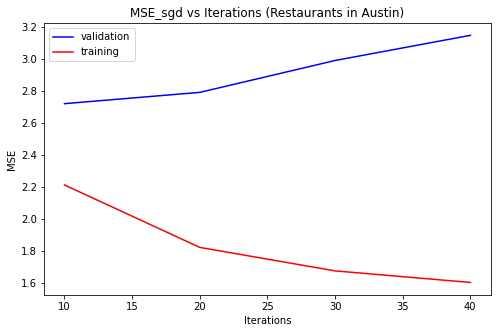

In [ ]:
iters = np.arange(10, 50, 10)
err_sgd_test = []
err_sgd_train = []
for i in iters:
    print('iters = ',i)
    preds_sgd = sgd(np.array(sm_u_10_austin_res_train.todense()), k=10, iterations= i)
    err_test = get_mse(preds_sgd[0], np.array(sm_u_10_austin_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_austin_res_train.todense()))
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(iters,err_sgd_test,'b-',label = 'validation')
plt.plot(iters,err_sgd_train,'r-', label = 'training')
plt.title('MSE_sgd vs Iterations (Restaurants in Austin)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

Optimal Number of Iterations = 20

k =  2
k =  3
k =  4
k =  6
k =  7
k =  9
k =  10
k =  12
k =  13
k =  15


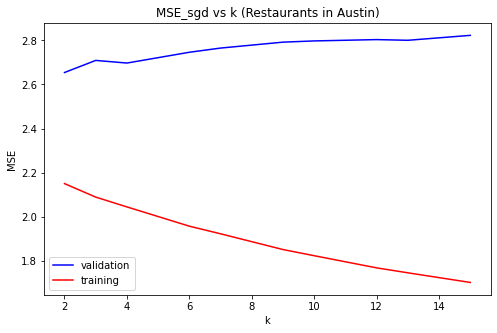

In [ ]:
k = np.linspace(2, 15, 10, dtype = int)
err_sgd_test = []
err_sgd_train = []
for i in k:
    print('k = ', i)
    preds_sgd = sgd(np.array(sm_u_10_austin_res_train.todense()), k=i, iterations= 20)
    err_test = get_mse(preds_sgd[0], np.array(sm_u_10_austin_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_austin_res_train.todense()))
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(k,err_sgd_test,'b-',label = 'validation')
plt.plot(k,err_sgd_train,'r-', label = 'training')
plt.title('MSE_sgd vs k (Restaurants in Austin)')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

Optimal K value = 2

In [ ]:
predictions_sgd_austin, error_array_sgd_austin, user_vec_sgd_austin, res_vec_sgd_austin = sgd(np.array(sm_u_10_austin_res_train.todense()), k=2, iterations= 20)

In [ ]:
preds_sgd_austin = sgd(np.array(sm_u_10_austin_res_train.todense()),k=2, iterations= 20)
Best_Val_MSE_sgd_austin = get_mse(preds_sgd_austin[0], np.array(sm_u_10_austin_res_val.todense()))
print('Best Validation MSE for SGD for Restaurants in Austin= ', Best_Val_MSE_sgd_austin)

Best Validation MSE for SGD for Restaurants in Austin=  2.6401222985696178


In [ ]:
train_preds_sgd_austin = preds_sgd_austin[0][train_austin_nnz]
val_preds_sgd_austin = preds_sgd_austin[0][val_austin_nnz]
test_preds_sgd_austin = preds_sgd_austin[0][test_austin_nnz]

## For Restaurants in Portland

iters =  10
iters =  20
iters =  30
iters =  40


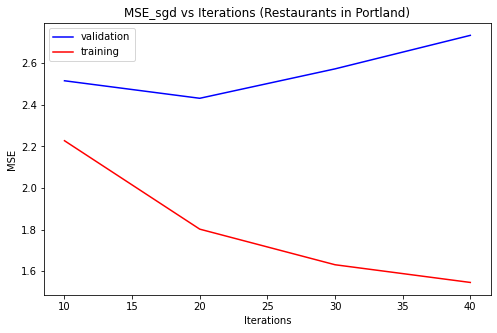

In [ ]:
iters = np.arange(10, 50, 10)
err_sgd_test_portland = []
err_sgd_train_portland = []
for i in iters:
    print('iters = ',i)
    preds_sgd = sgd(np.array(sm_u_10_portland_res_train.todense()), k=10, iterations= i)
    err_test = get_mse(preds_sgd[0], np.array(sm_u_10_portland_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_portland_res_train.todense()))
    err_sgd_test_portland.append(err_test)
    err_sgd_train_portland.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(iters,err_sgd_test_portland,'b-',label = 'validation')
plt.plot(iters,err_sgd_train_portland,'r-', label = 'training')
plt.title('MSE_sgd vs Iterations (Restaurants in Portland)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

Optimal Number of Iterations = 30

k= 2
k= 3
k= 4
k= 6
k= 7
k= 9
k= 10
k= 12
k= 13
k= 15


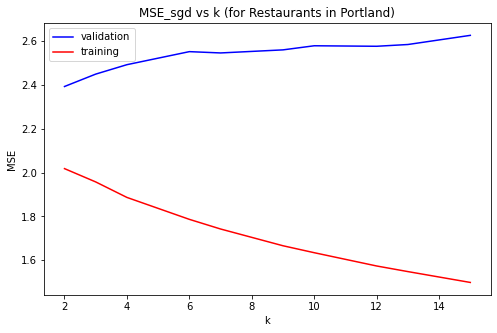

In [ ]:
k = np.linspace(2, 15, 10, dtype = int)
err_sgd_val_portland = []
err_sgd_train_portland = []
for i in k:
    print('k=', i)
    preds_sgd = sgd(np.array(sm_u_10_portland_res_train.todense()), k=i, iterations= 30)
    err_val = get_mse(preds_sgd[0], np.array(sm_u_10_portland_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_portland_res_train.todense()))
    err_sgd_val_portland.append(err_val)
    err_sgd_train_portland.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(k,err_sgd_val_portland,'b-',label = 'validation')
plt.plot(k,err_sgd_train_portland,'r-', label = 'training')
plt.title('MSE_sgd vs k (for Restaurants in Portland)')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

Optimal k value = 2

In [ ]:
predictions_sgd_portland, error_array_sgd_portland, user_vec_sgd_portland, res_vec_sgd_portland = sgd(np.array(sm_u_10_portland_res_train.todense()), k=2, iterations= 30)

In [ ]:
preds_sgd_portland = sgd(np.array(sm_u_10_portland_res_train.todense()),k=2, iterations=30)
Best_Val_MSE_sgd_portland = get_mse(preds_sgd_portland[0], np.array(sm_u_10_portland_res_val.todense()))
print('Best Validation MSE for SGD for Restaurants in Portland= ', Best_Val_MSE_sgd_portland)

Best Validation MSE for SGD for Restaurants in Portland=  2.4004604574361914


In [ ]:
train_preds_sgd_portland = preds_sgd_portland[0][train_portland_nnz]
val_preds_sgd_portland = preds_sgd_portland[0][val_portland_nnz]
test_preds_sgd_portland = preds_sgd_portland[0][test_portland_nnz]